In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import random
import time
import ipywidgets as widgets
from IPython.display import display

In [128]:
class Connect4:
    def __init__(self):
        self.board = np.zeros((6, 7), dtype=int)
        self.current_player = 1
    
    def reset(self):
        self.board = np.zeros((6, 7), dtype=int)
        self.current_player = 1
        return self.board
    
    def drop_piece(self, column):
        if not 0 <= column < 7 or self.board[0, column] != 0:
            print(f"[DEBUG] Invalid drop attempt in column {column}.")
            return False
        
        for row in range(5, -1, -1):
            if self.board[row, column] == 0:
                self.board[row, column] = self.current_player
                print(f"[DEBUG] Piece dropped for Player {self.current_player} in row {row}, column {column}.")
                if self.check_win(row, column):
                    print(f"[DEBUG] Player {self.current_player} won the game!")
                    return True
                self.current_player = 3 - self.current_player
                return True
        
        print(f"[DEBUG] No space found in column {column}.")
        return False
    
    def check_win(self, row, col):
        player = self.board[row, col]
        
        def count_consecutive(delta_row, delta_col):
            count = 0
            for i in range(1, 4):
                r, c = row + delta_row * i, col + delta_col * i
                if 0 <= r < 6 and 0 <= c < 7 and self.board[r, c] == player:
                    count += 1
                else:
                    break
            return count
        
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dr, dc in directions:
            if count_consecutive(dr, dc) + count_consecutive(-dr, -dc) >= 3:
                return True
        
        return False

    def calculate_rewards(self):
        reward = 0
        print("\n=== Calculating Rewards ===")
        print(f"Current Board State:\n{self.board}")
        
        # Reward for three-in-a-row
        if self.check_three_in_a_row(self.current_player):
            print(f"Player {self.current_player} made three in a row! +0.5 Reward")
            reward += 0.5

        # Reward for blocking opponent's three
        opponent = 3 - self.current_player
        if self.check_three_in_a_row(opponent):
            print(f"Player {self.current_player} blocked opponent's three! +0.3 Reward")
            reward += 0.3

        # Reward for controlling the center
        center_column = self.board[:, 3]
        center_control = np.sum(center_column == self.current_player)
        if center_control > 0:
            print(f"Player {self.current_player} controls the center! +0.1 Reward")
            reward += center_control * 0.1
        
        # Reward for making two in a row
        if self.check_two_in_a_row(self.current_player):
            print(f"Player {self.current_player} made two in a row! +0.2 Reward")
            reward += 0.2
        
        # Penalty for setting up an opponent trap
        if self.check_opponent_trap():
            print(f"Player {self.current_player} created an opponent trap! -0.3 Penalty")
            reward -= 0.3
        
        print(f"Total Reward: {reward}\n")
        return reward
    
    def check_three_in_a_row(self, player):
        """Check if the given player has three in a row."""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for row in range(6):
            for col in range(7):
                if self.board[row, col] == player:
                    for dr, dc in directions:
                        if self.count_in_line(row, col, dr, dc, player) == 2:
                            return True
        return False
    
    def check_two_in_a_row(self, player):
        """Check if the given player has two in a row with at least one open end."""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for row in range(6):
            for col in range(7):
                if self.board[row, col] == player:
                    for dr, dc in directions:
                        if self.count_in_line(row, col, dr, dc, player) == 1:
                            # Check for open ends
                            r1, c1 = row + dr * 2, col + dc * 2
                            if 0 <= r1 < 6 and 0 <= c1 < 7 and self.board[r1, c1] == 0:
                                return True
        return False
    
    def check_opponent_trap(self):
        """Check if the move created a trap for the opponent."""
        opponent = 3 - self.current_player
        for col in self.valid_moves():
            for row in range(5, -1, -1):
                if self.board[row, col] == 0:
                    self.board[row, col] = opponent
                    if self.check_win(row, col):
                        self.board[row, col] = 0
                        return True
                    self.board[row, col] = 0
        return False
    
    def count_in_line(self, row, col, delta_row, delta_col, player):
        count = 0
        for i in range(1, 3):
            r, c = row + delta_row * i, col + delta_col * i
            if 0 <= r < 6 and 0 <= c < 7 and self.board[r, c] == player:
                count += 1
            else:
                break
        return count
    
    def valid_moves(self):
        valid = [col for col in range(7) if self.board[0, col] == 0]
        print(f"[DEBUG] Valid moves available: {valid}")
        return valid
    
    def render(self):
        print(np.flip(self.board, 0))
    
    def is_full(self):
        return not np.any(self.board == 0)
    
    def get_state(self):
        """
        Returns the current state of the game and the current player.
        """
        state = self.board.copy()
        player = self.current_player
        print(f"[DEBUG] Current state fetched. Player: {player}")
        print(state)
        return (state, player)

    def simulate_move(self, state, player, action):
        """
        Simulates the move on a copy of the board for MCTS rollout.
        """
        board_copy = state.copy()
        for row in range(5, -1, -1):
            if board_copy[row, action] == 0:
                board_copy[row, action] = player
                break
        return (board_copy, 3 - player)  # Return the new state and the next player

In [129]:
class AlphaZeroNet(nn.Module):
    def __init__(self, board_rows=6, board_cols=7, action_size=7):
        super(AlphaZeroNet, self).__init__()

        # Input Layer: 2 channels (one for each player) + 1 for the current player's turn
        self.conv1 = nn.Conv2d(2, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        # Policy Head
        self.policy_head = nn.Sequential(
            nn.Conv2d(64, 2, 1),  # 1x1 conv for policy
            nn.Flatten(),
            nn.Linear(2 * board_rows * board_cols, action_size)
        )

        # Value Head
        self.value_head = nn.Sequential(
            nn.Conv2d(64, 1, 1),  # 1x1 conv for value
            nn.Flatten(),
            nn.Linear(board_rows * board_cols, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Tanh()  # Value is between -1 (loss) and 1 (win)
        )

    def forward(self, x):
        """
        Forward pass of the neural network.
        :param x: Input state of the game, shape (batch_size, 2, 6, 7)
        :return: Log probabilities of actions (policy), Estimated value of the board state (value)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        policy = self.policy_head(x)
        value = self.value_head(x)

        return F.log_softmax(policy, dim=1), value

In [132]:
class MCTS:
    def __init__(self, net, game, simulations=100, c_puct=1.0):
        self.net = net
        self.game = game
        self.simulations = simulations
        self.c_puct = c_puct
        
        # MCTS memory
        self.Q = defaultdict(float)     # Quality of the move
        self.N = defaultdict(int)       # Visit count for each state-action
        self.P = {}                     # Policy from the network
        self.children = defaultdict(dict)  # Child nodes for expansion
        print("[DEBUG] MCTS initialized.")
    
    def search(self, state):
        """
        Runs MCTS simulations to return action probabilities for a given state.
        """
        print("[DEBUG] MCTS search started.")
        print(f"[DEBUG] State received for MCTS:\n{state[0]}\nPlayer: {state[1]}")

        # 🚀 Initialize node if it's the first time it's seen
        if state not in self.P:
            print("[DEBUG] State not in MCTS. Running network for policy...")
            
            # Convert the state to a tensor
            state_tensor = self.state_to_tensor(state[0], state[1])

            # Pass it through the network
            policy, _ = self.net(state_tensor)
            policy = policy.detach().numpy().flatten()
            
            # Initialize children and policy
            valid_actions = self.game.valid_moves()
            self.P[state] = policy
            self.children[state] = {}
            
            # Expand children nodes
            for action in valid_actions:
                next_state = self.game.simulate_move(state[0], state[1], action)
                self.children[state][action] = next_state
        
        # 🚀 Perform search
        try:
            for _ in range(self.simulations):
                self.simulate(state)
        except Exception as e:
            print(f"[ERROR] MCTS simulation failed: {e}")
            return np.zeros(7)  # return zero probabilities to avoid crash

        # 🚀 Extract visit counts
        visit_counts = [self.N[(state, a)] for a in range(7)]
        print(f"[DEBUG] Visit counts from MCTS: {visit_counts}")
        
        # 🚀 Convert to probabilities
        total_visits = sum(visit_counts)
        if total_visits > 0:
            probs = np.array(visit_counts) / total_visits
        else:
            print("[DEBUG] No visits found; returning equal distribution.")
            probs = np.ones(7) / 7

        print(f"[DEBUG] MCTS action probabilities: {probs}")
        return probs
    
    def simulate(self, state):
        """
        Runs a single MCTS simulation from the given state.
        """
        print(f"[DEBUG] MCTS simulation started for state:\n{state[0]}\nPlayer: {state[1]}")
        path = []
        current_state = state

        try:
            # 🚀 **1. Selection Phase**
            print("[DEBUG] --- Selection Phase ---")
            while current_state in self.P and len(self.children[current_state]) > 0:
                action = max(self.children[current_state], key=lambda a: self.Q[(current_state, a)] + self.c_puct * self.P[current_state][a] * (np.sqrt(sum(self.N[(current_state, a)] for a in self.children[current_state])) / (1 + self.N[(current_state, a)])))
                path.append((current_state, action))
                current_state = self.children[current_state][action]
                print(f"[DEBUG] Selected action {action}, moving to next state.")

            # 🚀 **2. Expansion Phase**
            print("[DEBUG] --- Expansion Phase ---")
            if current_state not in self.P:
                print("[DEBUG] Expanding new node")
                state_tensor = self.state_to_tensor(current_state[0], current_state[1])
                policy, _ = self.net(state_tensor)
                policy = policy.detach().numpy().flatten()
                self.P[current_state] = policy

                # Generate children
                valid_actions = self.game.valid_moves()
                for action in valid_actions:
                    self.children[current_state][action] = self.game.simulate_move(current_state[0], current_state[1], action)

            # 🚀 **3. Backpropagation Phase**
            print("[DEBUG] --- Backpropagation Phase ---")
            reward = 1  # We assume a win here, replace this with proper simulation results
            for state, action in reversed(path):
                self.Q[(state, action)] += reward
                self.N[(state, action)] += 1
                reward = -reward  # Alternate reward

            print("[DEBUG] Simulation completed successfully.")
        
        except Exception as e:
            print(f"[ERROR] Simulation error: {e}")
            return 0
    
    def state_to_tensor(self, board, player):
        """
        Converts the board state and current player into a format suitable for the neural network.
        """
        print("[DEBUG] Converting state to tensor for the network.")
        board_tensor = torch.tensor(board, dtype=torch.float32).unsqueeze(0)
        player_tensor = torch.tensor([player], dtype=torch.float32).unsqueeze(0)
        return torch.cat((board_tensor, player_tensor), dim=1)

In [ ]:
game = Connect4()
mcts = MCTS(net=net, game=game, simulations=10)

# Reset game
game.reset()
state, player = game.get_state()

# Run a search and inspect
probs = mcts.search((state, player))
print("[TEST] MCTS returned probabilities:", probs)

[DEBUG] MCTS initialized.
[DEBUG] Current state fetched. Player: 1
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[DEBUG] MCTS search started.
[DEBUG] State received for MCTS:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Player: 1


TypeError: unhashable type: 'numpy.ndarray'

: 

In [92]:
class SelfPlay:
    def __init__(self, game, net, mcts, episodes=25):
        self.game = game
        self.net = net
        self.mcts = mcts
        self.episodes = episodes

    def run(self):
        training_data = []
        rewards = []

        for _ in range(self.episodes):
            self.game.reset()
            episode_data = []
            episode_reward = 0

            while not self.game.is_full():
                state, player = self.game.get_state()
                mcts_probs = self.mcts.search((state, player))
                episode_data.append((state.copy(), mcts_probs, player))
                
                # Pick an action from the MCTS probabilities
                action = np.random.choice(len(mcts_probs), p=mcts_probs)
                
                # 🚨 Prevent invalid moves
                if not self.game.drop_piece(action):
                    print(f"Invalid move detected at column {action}. Skipping this move.")
                    continue
                
                # Recalculate the reward
                reward = self.game.calculate_rewards()
                episode_reward += reward

                # ✅ **Detect win and break out**
                player_positions = np.where(self.game.board == player)
                win_detected = False
                for r, c in zip(player_positions[0], player_positions[1]):
                    if self.game.check_win(r, c):
                        print(f"🏆 Player {player} won the game! Stopping self-play for this game.")
                        winner = player
                        win_detected = True
                        break
                
                if win_detected:
                    # 🚀 Reset the board state here after a win
                    self.game.reset()
                    print("Game was won, resetting the board for the next round.")
                    break
            else:
                winner = 0  # Draw
                self.game.reset()
                print("Game ended in a draw, resetting the board for the next round.")
            
            if self.game.is_full():
                print("⚠️ Board is full. Ending the game loop.")
            break

            # Convert winner to reward signal
            for state, mcts_prob, player in episode_data:
                game_outcome = 1 if player == winner else -1 if winner != 0 else 0
                training_data.append((state, mcts_prob, game_outcome))
            
            rewards.append(episode_reward)

        avg_reward = sum(rewards) / len(rewards) if rewards else 0
        return training_data, avg_reward

In [93]:
def train(net, optimizer, memory, epochs=5, batch_size=64):
    net.train()
    for epoch in range(epochs):
        random.shuffle(memory)
        for i in range(0, len(memory), batch_size):
            batch = memory[i:i+batch_size]
            states, policies, values = zip(*batch)
            states = torch.tensor(states).float()
            policies = torch.tensor(policies).float()
            values = torch.tensor(values).float().unsqueeze(1)

            pred_policies, pred_values = net(states)
            loss_policy = -torch.mean(torch.sum(policies * pred_policies, dim=1))
            loss_value = F.mse_loss(pred_values, values)
            loss = loss_policy + loss_value

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [94]:
class Trainer:
    def __init__(self, net, lr=0.001):
        self.net = net
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
    
    def train(self, training_data, epochs=5, batch_size=64):
        """
        Train the network using self-play data.
        """
        print(f"Starting training with {len(training_data)} samples...")

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            random.shuffle(training_data)
            
            for i in range(0, len(training_data), batch_size):
                batch = training_data[i:i + batch_size]
                
                states, policies, values = zip(*batch)
                states = torch.tensor(states).float()
                policies = torch.tensor(policies).float()
                values = torch.tensor(values).float().unsqueeze(1)

                # Forward pass
                pred_policies, pred_values = self.net(states)
                
                # Loss calculation
                loss_policy = -torch.mean(torch.sum(policies * pred_policies, dim=1))
                loss_value = F.mse_loss(pred_values, values)
                loss = loss_policy + loss_value

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        print(f"Training complete.")

In [95]:
class MinimaxAgent:
    def __init__(self, depth=4):
        self.depth = depth

    def find_best_move(self, game):
        """
        Finds the best move using Minimax with Alpha-Beta pruning.
        """
        best_score = -math.inf
        best_move = None
        
        for action in game.valid_moves():
            game.drop_piece(action)
            score = self.minimax(game, self.depth, False, -math.inf, math.inf)
            game.board[action] = 0  # Undo move
            game.current_player = 1

            if score > best_score:
                best_score = score
                best_move = action
        
        return best_move
    
    def minimax(self, game, depth, maximizing, alpha, beta):
        if depth == 0 or game.is_full() or game.check_win(*np.where(game.board == 1)) or game.check_win(*np.where(game.board == 2)):
            return self.evaluate(game)

        if maximizing:
            max_eval = -math.inf
            for action in game.valid_moves():
                game.drop_piece(action)
                eval = self.minimax(game, depth - 1, False, alpha, beta)
                game.board[action] = 0
                game.current_player = 1
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = math.inf
            for action in game.valid_moves():
                game.drop_piece(action)
                eval = self.minimax(game, depth - 1, True, alpha, beta)
                game.board[action] = 0
                game.current_player = 2
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval
    
    def evaluate(self, game):
        """Heuristic evaluation of the board state."""
        if game.check_win(*np.where(game.board == 1)):
            return 1000
        elif game.check_win(*np.where(game.board == 2)):
            return -1000
        else:
            return 0

In [96]:
def plot_win_rates(results):
    """
    Plots the win rates of AlphaZero vs Random and Minimax.
    """
    iterations = list(range(1, len(results) + 1))
    random_wins = [res['random'] for res in results]
    minimax_wins = [res['minimax'] for res in results]
    draws = [res['draws'] for res in results]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, random_wins, label="AlphaZero vs Random Wins", marker='o')
    plt.plot(iterations, minimax_wins, label="AlphaZero vs Minimax Wins", marker='o')
    plt.plot(iterations, draws, label="Draws", marker='o')
    plt.title("AlphaZero Performance Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Games Won")
    plt.legend()
    plt.grid(True)
    plt.show()

In [97]:
# Initialize components
def train_alphazero(model=None, 
                    iterations=10, 
                    self_play_games=20, 
                    epochs_per_iteration=5, 
                    evaluation_games=10, 
                    save_interval=5, 
                    model_name="connect4_alphazero"):
    """
    Trains the AlphaZero model for Connect 4.
    
    Parameters:
    - model (AlphaZeroNet): Pre-initialized or loaded model. If None, a new model is created.
    - iterations (int): Number of training iterations.
    - self_play_games (int): Number of self-play games per iteration.
    - epochs_per_iteration (int): Number of epochs to train the model per iteration.
    - evaluation_games (int): Number of evaluation games against Minimax and Random.
    - save_interval (int): Frequency (in iterations) to save the model.
    - model_name (str): Base name for saved model checkpoints.
    
    Returns:
    - reward_history (list): Average rewards collected over each iteration.
    - results (list): Win/loss/draw results for evaluation.
    """
    # Initialize components
    game = Connect4()
    net = model if model else AlphaZeroNet()
    mcts = MCTS(net, game, simulations=50)
    self_play = SelfPlay(game, net, mcts, episodes=self_play_games)
    trainer = Trainer(net, lr=0.001)
    minimax_agent = MinimaxAgent(depth=3)

    # Tracking
    reward_history = []
    results = []

    # Training Loop
    for iteration in range(iterations):
        print(f"=== Iteration {iteration + 1}/{iterations} ===")

        # Step 1: Self-Play
        print(">> Self-play phase...")
        training_data, avg_reward = self_play.run()
        reward_history.append(avg_reward)

        # Step 2: Train the network
        print(">> Training phase...")
        trainer.train(training_data, epochs=epochs_per_iteration)

        # Step 3: Save the model periodically
        if (iteration + 1) % save_interval == 0:
            save_model(net, f"{model_name}_iter_{iteration + 1}.pth")

        # Step 4: Evaluation
        print(">> Evaluation phase...")
        net.eval()
        random_wins, minimax_wins, draws = 0, 0, 0

        for _ in range(evaluation_games):
            game.reset()

            while not game.is_full():
                state, player = game.get_state()
                
                if player == 1:
                    mcts_probs = mcts.search((state, player))
                    action = np.argmax(mcts_probs)
                else:
                    if np.random.rand() < 0.5:
                        action = np.random.choice(game.valid_moves())  # Random agent 50%
                    else:
                        action = minimax_agent.find_best_move(game)    # Minimax agent 50%

                if not game.drop_piece(action):
                    print(f"Invalid move attempted by Player {player} at column {action}.")
                    break
                
                # ✅ Loop through each player piece position
                win_detected = False
                player_positions = np.where(game.board == player)
                for r, c in zip(player_positions[0], player_positions[1]):
                    if game.check_win(r, c):
                        if player == 1:
                            random_wins += 1
                        else:
                            minimax_wins += 1
                        win_detected = True
                        break
                
                if win_detected:
                    break
            else:
                draws += 1
        
        # Collect results
        results.append({
            'random': random_wins,
            'minimax': minimax_wins,
            'draws': draws
        })
        
        print(f"Results after iteration {iteration + 1}:")
        print(f"  AlphaZero Wins (Random): {random_wins}")
        print(f"  AlphaZero Wins (Minimax): {minimax_wins}")
        print(f"  Draws: {draws}")
        print("\n==========================\n")

    # Plotting
    plot_rewards(reward_history)
    plot_win_rates(results)
    
    return reward_history, results

In [98]:
def plot_rewards(reward_history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, marker='o')
    plt.title("Average Reward per Self-Play Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Avg Reward")
    plt.grid(True)
    plt.show()

=== Iteration 1/5 ===
>> Self-play phase...
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Player 1 won the game!
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 1.
Invalid move attempted at column 

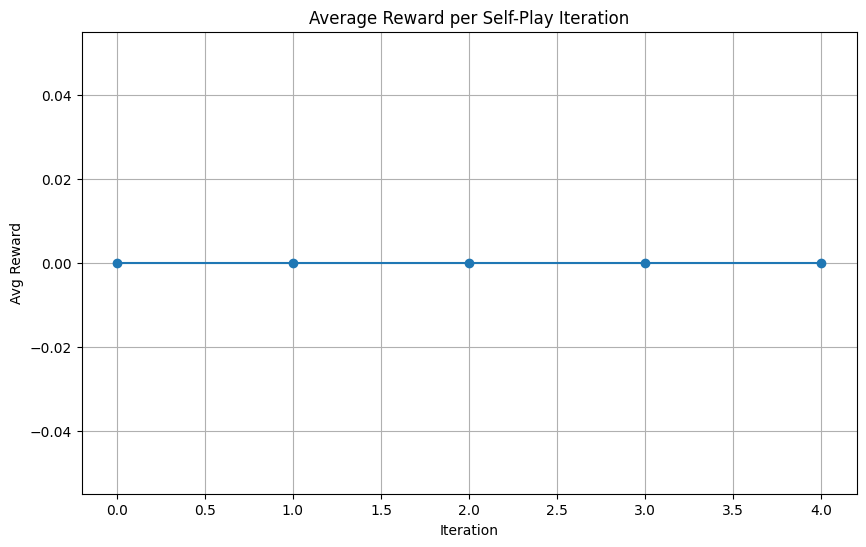

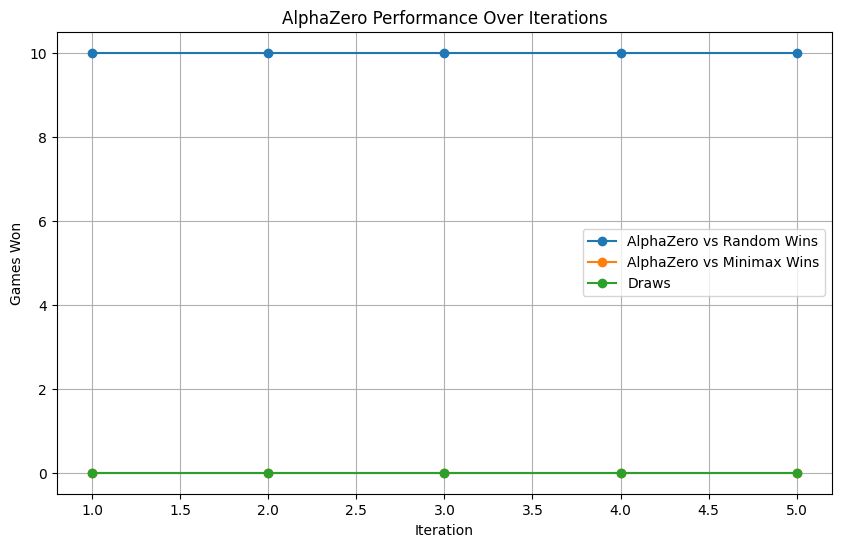

In [99]:
# Initialize the model
#if loading from previously trained
#net = AlphaZeroNet()
#load_model(net, "connect4_alphazero_iter_10.pth")
#reward_history, results = train_alphazero(model=net, iterations=20, self_play_games=30)



reward_history, results = train_alphazero(iterations=5, self_play_games=20)

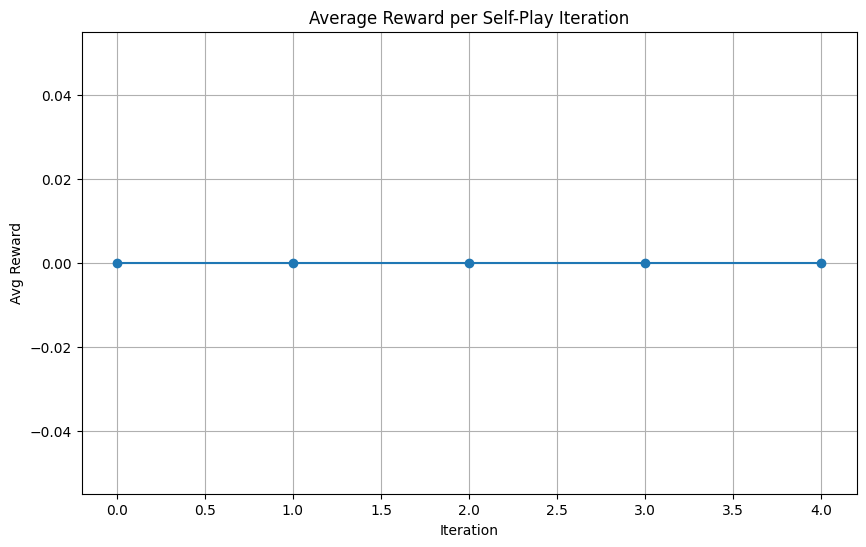

In [100]:
plot_rewards(reward_history)

In [112]:
def save_model(model, filepath="connect4_alphazero.pth"):
    """
    Saves the AlphaZero model to a file.
    :param model: The neural network model to be saved.
    :param filepath: Path where the model is saved.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}.")

def load_model(model, filepath="connect4_alphazero.pth"):
    """
    Loads the AlphaZero model from a file.
    :param model: The neural network model instance.
    :param filepath: Path from which the model is loaded.
    """
    model.load_state_dict(torch.load(filepath))
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {filepath}.")

In [126]:
class Connect4UI:
    def __init__(self, model, ai_player=-1):
        self.env = Connect4()
        self.model = model
        self.mcts = MCTS(self.model, self.env, simulations=50)
        self.ai_player = ai_player
        self.create_ui()
        self.initialize_game_state()

    def initialize_game_state(self):
        print("Game initialized. AI Player is:", self.ai_player)
        self.state = self.env.reset()
        self.done = False
        self.update_display()
        
        # 🚀 Update: If AI is the starter, let it make the first move
        if self.env.current_player == self.ai_player:
            print("AI is starting the game...")
            time.sleep(0.5)
            self.make_ai_move()
        else:
            print("You are starting the game...")

    def create_ui(self):
        self.title = widgets.HTML(value="<h1 style='text-align: center;'>Connect 4</h1>")
        self.status = widgets.HTML(value="<h3 style='text-align: center;'>Game ready! Make your move</h3>")
        self.buttons = []

        # 🚀 Create buttons with explicit function binding
        def make_button_callback(col):
            def callback(b):
                print(f"[DEBUG] Button clicked for column {col}")
                self.make_move(col)
            return callback
        
        for col in range(7):
            btn = widgets.Button(description=str(col), layout=widgets.Layout(width='60px', height='40px'))
            btn.on_click(make_button_callback(col))  # ✅ Properly bound to the column
            self.buttons.append(btn)

        self.button_container = widgets.HBox(self.buttons, layout=widgets.Layout(justify_content='center'))
        self.board_display = widgets.HTML(value=self.render_board_html())
        self.player_starter = widgets.RadioButtons(
            options=[('You start (X)', 1), ('AI starts (O)', -1)],
            value=-1, description='New Game:', layout=widgets.Layout(width='300px'))
        self.new_game_button = widgets.Button(description="Start New Game", button_style='primary', layout=widgets.Layout(width='150px'))
        self.new_game_button.on_click(self.start_new_game)
        self.game_controls = widgets.HBox([self.player_starter, self.new_game_button], layout=widgets.Layout(justify_content='center', margin='20px 0'))
        self.app = widgets.VBox([self.title, self.status, self.button_container, self.board_display, self.game_controls], layout=widgets.Layout(width='100%', align_items='center'))
        display(self.app)

    def start_new_game(self, b):
        selected_value = self.player_starter.value
        self.ai_player = -selected_value
        self.state = self.env.reset()
        self.done = False

        # 🚀 Correctly sync the starting player
        self.env.current_player = 1 if selected_value == 1 else 2
        print(f"Game started. Current Player: {'You' if self.env.current_player == 1 else 'AI'}")

        # Enable all buttons for playing
        for btn in self.buttons:
            btn.disabled = False

        self.update_display()
        
        # 🚀 If AI starts, make the move immediately
        if self.env.current_player == self.ai_player:
            print("AI is starting the game...")
            time.sleep(0.5)
            self.make_ai_move()

    def render_board_html(self):
        html = """
        <style>
        .board { background-color: #0052cc; display: inline-block; padding: 10px; border-radius: 10px; }
        .cell { width: 60px; height: 60px; background-color: #ffffff; border-radius: 50%; display: inline-block; margin: 5px; }
        .player1 { background-color: #ff0000; }
        .player2 { background-color: #ffff00; }
        </style>
        <div class="board">
        """
        for row in range(6):
            html += "<div>"
            for col in range(7):
                cell_value = self.env.board[row, col]
                cell_class = f"cell player{cell_value}" if cell_value != 0 else "cell"
                html += f'<div class="{cell_class}"></div>'
            html += "</div>"
        html += "</div>"
        return html

    def update_display(self):
        """
        Refreshes the display of the board and the game status.
        """
        print(f"[DEBUG] Current board state:\n{self.env.board}")
        self.board_display.value = self.render_board_html()
        if self.done:
            if self.env.is_full():
                message = "Draw game! 🤝"
                color = "blue"
            elif self.env.current_player == 1:
                message = "You win! 🎉"
                color = "green"
            else:
                message = "AI wins! 🤖"
                color = "red"

            self.status.value = f"<h3 style='text-align: center; color: {color};'>{message}</h3>"
            
            # 🚀 Disable buttons after the game is over
            for btn in self.buttons:
                btn.disabled = True

        else:
            current_player = self.env.current_player
            player_name = "Your" if current_player == 1 else "AI's"
            self.status.value = f"<h3 style='text-align: center;'>{player_name} turn</h3>"

    def make_move(self, column):
        """
        Human player makes a move.
        """
        print(f"[DEBUG] make_move called for column {column}")

        if self.done:
            print("[DEBUG] Game is already finished.")
            return
        
        if self.env.current_player != 1:
            print("[DEBUG] It's not your turn.")
            return
        
        if column not in self.env.valid_moves():
            print("[DEBUG] Invalid move! Column is full or not available.")
            return

        print(f"[DEBUG] You made a move in column {column}")
        success = self.env.drop_piece(column)

        if not success:
            print(f"[DEBUG] Could not drop piece in column {column}")
            return

        print(f"[DEBUG] Piece successfully dropped in column {column}")
        self.update_display()
        
        # ✅ Check for winner after the move
        if self.check_for_winner():
            print("[DEBUG] Game Over! You won!")
            self.done = True
            self.update_display()
            return
        
        # ✅ Change turn to AI
        print("[DEBUG] Switching to AI turn...")
        self.env.current_player = 2

        # ✅ AI's turn if the game is not finished
        if not self.done and self.env.current_player == self.ai_player:
            print("[DEBUG] AI is thinking...")
            time.sleep(0.5)
            self.make_ai_move()

    def make_ai_move(self):
        """
        AI player makes a move.
        """
        if self.done:
            print("[DEBUG] Game is already finished. AI will not make a move.")
            return
        
        if self.env.current_player != self.ai_player:
            print(f"[DEBUG] It's not the AI's turn. Current player: {self.env.current_player}")
            return

        valid_actions = self.env.valid_moves()
        if not valid_actions:
            print("[DEBUG] No valid moves for AI.")
            return

        print("[DEBUG] AI is searching for the best move...")

        # 🚀 Get the full state (board + player turn)
        state, player = self.env.get_state()
        print(f"[DEBUG] AI is thinking... Current player: {player}")

        # 🚀 Perform MCTS search
        try:
            probs = self.mcts.search((state, player))
        except Exception as e:
            print(f"[ERROR] MCTS search failed with error: {e}")
            return
        
        # 🚀 Debugging to see probabilities
        print(f"[DEBUG] MCTS probabilities: {probs}")

        if np.sum(probs) == 0 or len(probs) != 7:
            print("[DEBUG] MCTS failed to produce valid moves. Choosing randomly.")
            action = np.random.choice(valid_actions)
        else:
            action = np.argmax(probs)

        print(f"[DEBUG] AI decided to move in column {action}")
        
        # 🚀 Attempt to drop the piece
        if not self.env.drop_piece(action):
            print(f"[DEBUG] AI failed to drop the piece in column {action}.")
            return
        
        print(f"[DEBUG] AI successfully placed a piece in column {action}")
        self.update_display()
        
        # ✅ Check for winner after AI's move
        if self.check_for_winner():
            print("[DEBUG] Game Over! AI won!")
            self.done = True
            self.update_display()
            return

        # ✅ Change turn back to the player
        print("[DEBUG] Switching back to Your turn...")
        self.env.current_player = 1

    def check_for_winner(self):
        """
        Checks if there is a winner after the last move.
        """
        player_positions = np.where(self.env.board == self.env.current_player)
        for r, c in zip(player_positions[0], player_positions[1]):
            if self.env.check_win(r, c):
                print(f"🏆 Player {self.env.current_player} won the game!")
                self.done = True
                return True

        # 🚀 Check for a draw
        if self.env.is_full():
            print("The game is a draw.")
            self.done = True
            return True

        # 🚀 Change turn if no winner
        self.env.current_player = 3 - self.env.current_player
        return False

In [127]:
net = AlphaZeroNet()
load_model(net, "connect4_alphazero_iter_20.pth")
game_ui = Connect4UI(model=net, ai_player=-1)

Model loaded from connect4_alphazero_iter_20.pth.


C:\Users\ajmat\AppData\Local\Temp\ipykernel_119232\3652885279.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Game initialized. AI Player is: -1
[DEBUG] Current board state:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
You are starting the game...
